In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from rsnn.set.firing_sequences import f_sample

In [3]:
%matplotlib inline

In [28]:
def plot_count(sampling, length, Tr, num_exp=50000):
    plt.figure(figsize = (10,3))
    data = pd.DataFrame({"sequences":[''.join(map(str, sampling(length,Tr))) for _ in range(num_exp)]})
    ax = sns.countplot(data=data, x="sequences", palette="ch:s=.2,r=-.3")
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.show()

## Periodic firing sequences

In [29]:
length, Tr = 7, 2

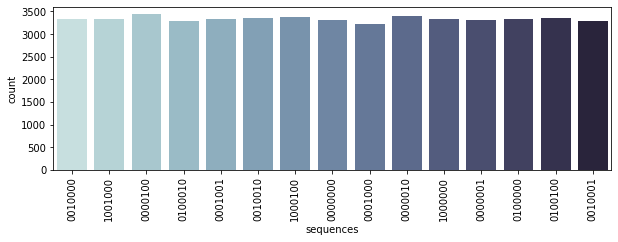

In [30]:
sampling = lambda length, Tr : f_sample(length, Tr, ends_with=tuple())
plot_count(sampling, length, Tr)

## Aperiodic firing sequences

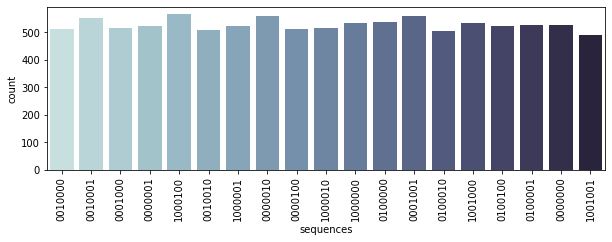

In [21]:
sampling = lambda length, Tr : backward_filtering_forward_sampling(length, Tr, loop=False)
plot_count(sampling, length, Tr)

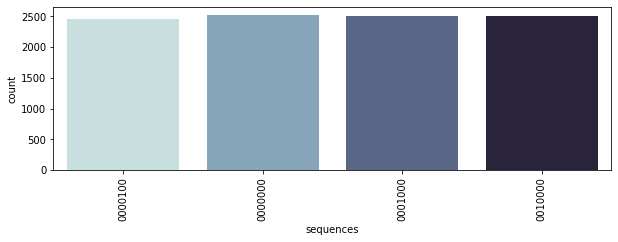

In [22]:
# with fixed start AND end
sampling = lambda length, Tr : backward_filtering_forward_sampling(length, Tr, s_lim=(0, 0), loop=False)
plot_count(sampling, length, Tr)

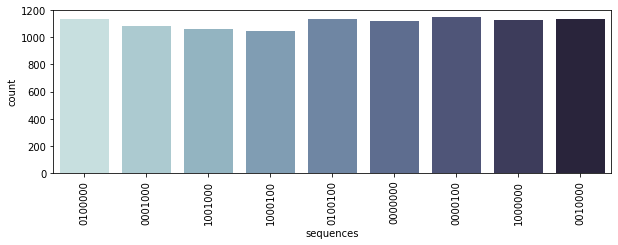

In [23]:
# with fixed end
sampling = lambda length, Tr : backward_filtering_forward_sampling(length, Tr, s_lim=(None,0), loop=False)
plot_count(sampling, length, Tr)

In [64]:
def msg_to_seq(msg, Tr):
    seq = []
    for b in msg:
        seq += [b] + [0]*Tr if b > 0 else [b]
    return seq

def seq_to_msg(seq, Tr):
    length = len(seq)
    msg = []
    i = 0
    while i < length:
        b = seq[i]
        msg.append(b)
        if b > 0:
            i += Tr + 1
        else:
            i += 1
    return msg

In [65]:
msg = np.random.binomial(1, 0.5, (5))
msg

array([0, 1, 1, 1, 1])

In [66]:
seq = msg_to_seq(msg, Tr)
seq

[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]

In [133]:
# single channel encryption
def generate_key(seq, Tr, key_len, num_channels, c_star=0):
    def mapping(seq_):
        if np.sum(seq_) < 1:
            return 0
        else:
            return np.argmax(seq_) + 1
        
    key = np.empty((num_channels, key_len), int)
    
    # generate all other keys
    for c in range(num_channels):
        if c == c_star:
            s_left = mapping(seq[-Tr:])
            s_right = mapping(seq[0:Tr])
            key[c] = backward_filtering_forward_sampling(key_len+2*Tr, Tr, s_lim=(s_left, s_right), loop=False)[Tr:Tr+key_len]
        
        else:
            key[c] = backward_filtering_forward_sampling(key_len + len(seq), Tr, loop=True)[:key_len]
    
    return key

In [134]:
key_len = 5
num_channels = 1

key = generate_key(seq, Tr, key_len, num_channels)
key[0], seq

(array([0, 0, 1, 0, 0]), [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [135]:
is_valid(np.concatenate((key[0], seq)), len(seq) + key_len, Tr)

True

In [143]:
def mapping(seq_):
    if np.sum(seq_) < 1:
        return 0
    else:
        return np.argmax(seq_) + 1

In [183]:
# multi channel encryption
key_len = 5
num_channels = 5
msg = np.random.binomial(1, 0.5, (20))
channel_msg = np.array_split(msg, num_channels)
channel_seq_len = []

for c in range(num_channels):
    channel_seq = msg_to_seq(channel_msg[c], Tr)
    channel_seq_len.append(len(msg_to_seq(channel_msg[c], Tr)))
    
channel_seq = []
keys = []
for c in range(num_channels):
    channel_seq.append(msg_to_seq(channel_msg[c], Tr) + [0]*(max(channel_seq_len) - channel_seq_len[c]))
    
    s_left = mapping(channel_seq[c][-Tr:])
    s_right = mapping(channel_seq[c][0:Tr])
    
    keys.append(backward_filtering_forward_sampling(key_len+2*Tr, Tr, s_lim=(s_left, s_right), loop=False)[Tr:Tr+key_len])

In [184]:
channel_seq

[[1, 0, 0, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0]]

In [185]:
channel_seq_len

[8, 8, 6, 6, 8]

In [186]:
keys

[[0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0],
 [1, 0, 0, 1, 0],
 [0, 1, 0, 0, 0]]

In [188]:
msg

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0])

In [187]:
for c in range(num_channels):
    print(seq_to_msg(channel_seq[c][:channel_seq_len[c]], Tr))

[1, 0, 1, 0]
[0, 1, 0, 1]
[0, 0, 0, 1]
[0, 1, 0, 0]
[1, 1, 0, 0]


In [191]:
from scipy.special import lambertw
import math

In [229]:
eps = 1e-3
beta = - 5 / np.real_if_close(lambertw(-eps/math.exp(1), -1))
beta

0.4885955220616903

In [230]:
h = lambda t: t/beta * math.exp(1-t/beta)
h(5)

0.0009999999999999996

In [259]:
T = 3
Tr = 2
eps = 1e-3
num_neurons = 3
num_synapses = 2
w_lim = (-1, 1)

data = np.random.binomial(1, 0.5, (3, 5))
beta = -T / np.real_if_close(lambertw(-eps / np.exp(1), -1))
impulse_response = lambda t: t / beta * np.exp(1 - t / beta)

origins = np.random.randint(0, num_neurons, (num_neurons, num_synapses))
delays = np.random.uniform(0, Tr, (num_neurons, num_synapses))
weights = np.random.uniform(*w_lim, (num_neurons, num_synapses))

In [260]:
length = data.shape[1]
grid = np.arange(-T, 0)

z = np.sum(
    [
        impulse_response(-grid[None, None, :] - delays[:, :, None]) * np.roll(data[origins], -l, axis=-1)[:,:, -T:]
        for l in range(length)
    ],
    axis=-1,
)
z

array([[[ 7.34922261e-01,  8.63086596e-01],
        [-8.69653541e+01, -1.60065387e+02],
        [-1.02283970e+01,  4.02625798e-01]],

       [[ 7.34922261e-01,  8.63086596e-01],
        [ 1.15163157e+00,  9.80167461e-01],
        [ 7.15059934e-01,  4.30960275e-01]],

       [[ 7.34922261e-01,  8.63086596e-01],
        [ 1.61181794e-01,  2.25017439e-01],
        [ 5.54019123e-02,  4.32392000e-01]],

       [[ 7.34922261e-01,  8.63086596e-01],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  2.97662016e-02]],

       [[ 7.34922261e-01,  8.63086596e-01],
        [-8.79558039e+01, -1.60820537e+02],
        [-1.08880550e+01,  1.43172510e-03]]])

In [265]:
grid.shape[0]

5

In [261]:
length = data.shape[1]
grid = np.arange(-length, 0)

z = np.sum(
    [
        impulse_response(-grid[None, None, :] - delays[:, :, None]) * np.roll(data[origins], -l, axis=-1)
        for l in range(length)
    ],
    axis=-1,
)
z

array([[[ 7.35066866e-01,  8.63277684e-01],
        [-8.69653541e+01, -1.60065387e+02],
        [-1.02283970e+01,  4.02692081e-01]],

       [[ 7.35066866e-01,  8.63277684e-01],
        [ 1.15163157e+00,  9.80167461e-01],
        [ 7.15059934e-01,  4.30962916e-01]],

       [[ 7.35066866e-01,  8.63277684e-01],
        [ 1.70742125e-01,  2.39047683e-01],
        [ 5.83403149e-02,  4.32392000e-01]],

       [[ 7.35066866e-01,  8.63277684e-01],
        [ 1.00158162e-02,  1.47112440e-02],
        [ 3.07201251e-03,  2.98298429e-02]],

       [[ 7.35066866e-01,  8.63277684e-01],
        [-8.79553484e+01, -1.60819856e+02],
        [-1.08879214e+01,  1.49800760e-03]]])

In [244]:
z.shape

(20, 10, 7)